# Constrained Least Squares

Assume we have a dataset for which we want to do regression on. We know this dataset is divided into reliable and unreliable data, such that it takes the form 
$$\begin{align}
    A_1 x &\approx b_1\\
    A_2 x &= b_2
  \end{align}
$$
Consequently we have the program:
$$\begin{align}
    \min_x \quad &\frac{1}{2} \| A_1 x - b_1\|^2 \\
    \text{s.t.} \quad &A_2 x = b_2
  \end{align}
$$

We capture the constraint by projecting the gradient descent function onto the set $C$ which is defined as $$C = \{x \in \mathbb{R}^n : Ax = b\}.$$ The formula for the projection onto $C$ using the Moore-Penrose pseudo-inverse is $$P_C(z) = z - (A^{\intercal} A)^{-1} A^{\intercal}(Az - b).$$

If  $$A^+ = (A^{\intercal} A)^{-1} A^{\intercal}$$ the above reduces to $$ P_C(z) = z - A^+(Az - b).$$


We thus have the following procedure:
$$\begin{align}
f(x) &= \frac{1}{2} \| A_1 x - b_1\|^2 \\
\nabla f(x) &= A_1^{\intercal} (A_1 x - b_1)\\
y^k &= x^k - \lambda \nabla f(x^k)\\
&= x^k - \lambda \nabla \big(A_1^{\intercal} (A_1 x^k - b_1)\big)\\
x^{k+1} &= P_C(y^k)\\
&= y^k - A_2^+ (A_2 y^k - b_2)\\
&= x^k - \lambda \nabla f(x^k) - A_2^+ \big(A_2(x^k - \lambda \nabla f(x^k)) - b_2\big)\\
&= x^k - \lambda \nabla \big(A_1^{\intercal} (A_1 x^k - b_1)\big) - (A_2^{\intercal} A_2)^{-1} A_2^{\intercal}\Bigg(A_2\bigg(x^k - \lambda \nabla \big(A_1^{\intercal} (A_1 x^k - b_1)\big)\bigg) - b_2\Bigg)
\end{align}$$

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from copy import deepcopy
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
def ren(y): return range(len(y))
rng = np.random.default_rng()

In [2]:
def f(x,A,b): # function
    return 0.5*(np.linalg.norm( A @ x - b )**2)
def f_grad(x,A,b): # gradient function
    return A.T @ ( A @ x - b )
def y(x,grad,lam): # `classic' gradient descent
    return x - lam*grad
def GD_P(Y, A, Ainv, b): # Projection function
    return Y - Ainv @ (A@Y - b)

DS = make_regression() # generate regression dataset
A1, A2, b1, b2 = train_test_split(DS[0],DS[1], test_size=0.1) # break data into two sections
b1 = np.array([i+rng.uniform(-1,1)*10 for i in b1]) # warp the unreliable data
A2inv = np.linalg.pinv(A2) # calculate the pseudo inverse of A2
x0 = rng.random(len(A1[0])) # generate a len n vector x
epsilon = 1e-6

# Vanilla

In [3]:
init_time = time.time()
x0 = rng.random(len(A1[0])) # generate a len n vector x
lam = 1/np.max(np.linalg.svd(A1@A1.T)[1]) # 1/L
Grad = f_grad(x0,A1,b1)
y0 = y(x0,Grad,lam) # perform `classic' gradient descent part
x1 = GD_P(y0, A2, A2inv, b2) # calculate projection onto C
ApproxGrad = (x1-x0)/lam
ApproxGradNorm = np.linalg.norm(ApproxGrad)
AprGrList = [ApproxGradNorm]
timeList = [time.time() - init_time]
while ApproxGradNorm > epsilon:
    Grad = f_grad(x1,A1,b1)
    yk = y(x1,Grad,lam)
    x0 = deepcopy(x1)
    x1 = GD_P(yk,A2,A2inv,b2)
    ApproxGrad = (x1-x0)/lam
    ApproxGradNorm = np.linalg.norm(ApproxGrad)
    AprGrList.append(ApproxGradNorm)
    timeList.append(time.time() - init_time)

KeyboardInterrupt: 

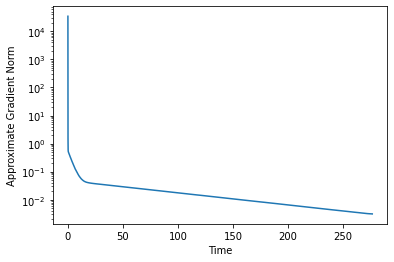

In [4]:
plt.plot(timeList,AprGrList)
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Approximate Gradient Norm')
plt.show()

In [5]:
MSE(b1,A1@x1)

5.664254445078451e-13

In [7]:
np.allclose(A1@x1,b1)

True

In [8]:
np.allclose(A2@x1,b2)

True

# Adaptive

In [9]:
init_time = time.time()
x0 = rng.random(len(A1[0])) # generate a len n vector x
oldGrad = f_grad(x0, A1, b1)
lam = rng.random()+1e-12
theta = np.inf
y0 = y(x0,oldGrad,lam) # perform `classic' gradient descent part
x1 = GD_P(y0, A2, A2inv, b2) # calculate projection onto C
Grad = f_grad(x1, A1, b1)
ApproxGrad = (x1-x0)/lam
ApproxGradNorm = np.linalg.norm(ApproxGrad)
AprGrList = [ApproxGradNorm]
timeList = [time.time() - init_time]
while ApproxGradNorm > epsilon:
    lam0 = deepcopy(lam)
    min1 = np.sqrt(1 + theta)*lam0
    min2Nom = np.linalg.norm(x1 - x0)
    min2Denom = 2*np.linalg.norm(Grad - oldGrad)
    lam = np.min([min1, min2Nom/min2Denom])
    yk = y(x1,Grad,lam)
    x0 = deepcopy(x1)
    x1 = GD_P(yk,A2,A2inv,b2)
    oldGrad = deepcopy(Grad)
    Grad = f_grad(x1,A1,b1)
    ApproxGrad = (x1-x0)/lam
    ApproxGradNorm = np.linalg.norm(ApproxGrad)
    AprGrList.append(ApproxGradNorm)
    timeList.append(time.time() - init_time)

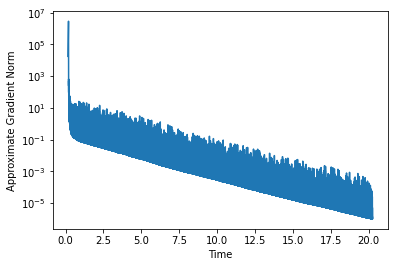

In [10]:
plt.plot(timeList,AprGrList)
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Approximate Gradient Norm')
plt.show()

In [11]:
np.allclose(A1@x1,b1)

True

In [12]:
np.allclose(A2@x1,b2)

True

# Line Search

In [65]:
init_time = time.time()
x1 = rng.random(len(A1[0])) # generate a len n vector x
Grad = f_grad(x1,A1,b1)
ApproxGrad = deepcopy(Grad)
ApproxGradNorm = np.linalg.norm(ApproxGrad)
AprGrList = [ApproxGradNorm]
timeList = [time.time() - init_time]
while ApproxGradNorm > epsilon:
    LStime = time.time()
    rho = rng.random()+1e-12
    Lam = rng.uniform(0.1,10)
    while np.linalg.norm(f_grad(x1 - Lam*Grad, A1,b1) - Grad) > np.linalg.norm(Grad):
        Lam = rho*Lam
        if time.time() - LStime > 10:
            break
    lam = Lam
    Grad = f_grad(x1,A1,b1)
    yk = y(x1,Grad,lam)
    x0 = deepcopy(x1)
    x1 = GD_P(yk,A2,A2inv,b2)
    ApproxGrad = (x1-x0)/lam
    ApproxGradNorm = np.linalg.norm(ApproxGrad)
    AprGrList.append(ApproxGradNorm)
    timeList.append(time.time() - init_time)
    if timeList[-1] > 600:
        break

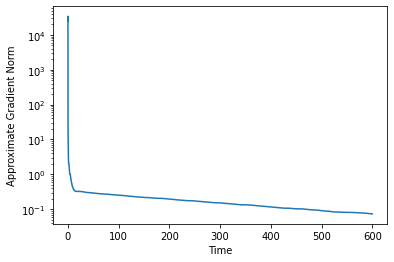

In [66]:
plt.plot(timeList,AprGrList)
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Approximate Gradient Norm')
plt.show()

In [67]:
np.allclose(A1@x1,b1)

False

In [68]:
np.allclose(A2@x1,b2)

True

### Helping line search along

In [60]:
Help = 1/np.max(np.linalg.svd(A1@A1.T)[1])

In [61]:
init_time = time.time()
x1 = rng.random(len(A1[0])) # generate a len n vector x
Grad = f_grad(x1,A1,b1)
ApproxGrad = deepcopy(Grad)
ApproxGradNorm = np.linalg.norm(ApproxGrad)
AprGrList = [ApproxGradNorm]
timeList = [time.time() - init_time]
while ApproxGradNorm > epsilon:
    LStime = time.time()
    rho = rng.random()+1e-12
#     Lam = rng.uniform(0.1,10)
    Lam = Help
    while np.linalg.norm(f_grad(x1 - Lam*Grad, A1,b1) - Grad) > np.linalg.norm(Grad):
        Lam = rho*Lam
        if time.time() - LStime > 10:
            break
    lam = Lam
    Grad = f_grad(x1,A1,b1)
    yk = y(x1,Grad,lam)
    x0 = deepcopy(x1)
    x1 = GD_P(yk,A2,A2inv,b2)
    ApproxGrad = (x1-x0)/lam
    ApproxGradNorm = np.linalg.norm(ApproxGrad)
    AprGrList.append(ApproxGradNorm)
    timeList.append(time.time() - init_time)
    if timeList[-1] > 600:
        break

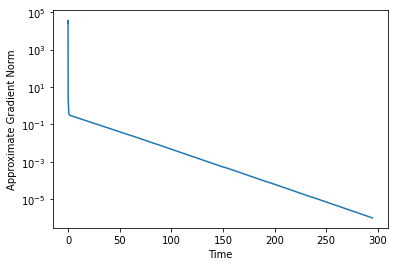

In [62]:
plt.plot(timeList,AprGrList)
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Approximate Gradient Norm')
plt.show()

In [63]:
np.allclose(A1@x1,b1)

True

In [64]:
np.allclose(A2@x1,b2)

True

# Barzilai-Borwein

In [10]:
init_time = time.time()
x0 = rng.random(len(A1[0])) # generate a len n vector x
oldGrad = f_grad(x0, A1, b1)
lam = rng.random()+1e-12
y0 = y(x0,oldGrad,lam) # perform `classic' gradient descent part
x1 = GD_P(y0, A2, A2inv, b2) # calculate projection onto C
Grad = f_grad(x1, A1, b1)
ApproxGrad = (x1-x0)/lam
ApproxGradNorm = np.linalg.norm(ApproxGrad)
AprGrList = [ApproxGradNorm]
timeList = [time.time() - init_time]
while ApproxGradNorm > epsilon:
    Nom = np.dot(x1 - x0, Grad - oldGrad)
    Denom = np.linalg.norm(Grad - oldGrad)**2
    lam = Nom/Denom
    yk = y(x1,Grad,lam)
    x0 = deepcopy(x1)
    x1 = GD_P(yk,A2,A2inv,b2)
    oldGrad = deepcopy(Grad)
    Grad = f_grad(x1,A1,b1)
    ApproxGrad = (x1-x0)/lam
    ApproxGradNorm = np.linalg.norm(ApproxGrad)
    AprGrList.append(ApproxGradNorm)
    timeList.append(time.time() - init_time)

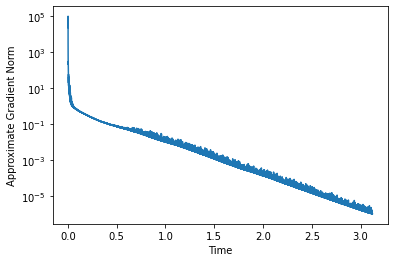

In [11]:
plt.plot(timeList,AprGrList)
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Approximate Gradient Norm')
plt.show()

In [16]:
np.allclose(A1@x1,b1)

True

In [17]:
np.allclose(A2@x1,b2)

True

# Nesterov Acceleration

In [3]:
epsilon = 1e-6

In [5]:
init_time = time.time()
x0 = rng.random(len(A1[0]))
lam0 = 1
lam1 = (1/2)*(1+ np.sqrt(1 + 4*lam0**2))
y0 = x0 - A2inv@( A2@x0 - b2 )
y1 = deepcopy(y0)
L = np.max(np.linalg.svd(A1@A1.T)[1]) # L
stopper = np.linalg.norm(y1 - x0)/(1/L)
approxGradList = [stopper]
while stopper > epsilon: # (y1 - x0)/(1/L)
    grad = A1.T@(A1@x0 - b1)
    z1 = x0 - (1/L)*grad
    y1 = z1 - A2inv@( A2@z1 - b2 ) # projection 
    lam2 = (1/2)*(1+ np.sqrt(1 + 4*lam1**2))
    gamma = (1-lam0)/lam2
    lam0 = deepcopy(lam1)
    lam1 = deepcopy(lam2)
    x1 = (1-gamma)*y1 + gamma*y0
    stopper = np.linalg.norm(y1 - x0)/(1/L)
    approxGradList.append(stopper)
    x0 = deepcopy(x1)
    y0 = deepcopy(y1)
    if time.time() - init_time > 30:
        break


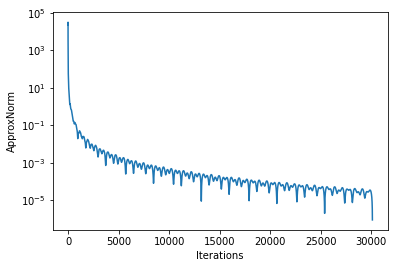

In [9]:
plt.plot(ren(approxGradList), approxGradList)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('ApproxNorm')
plt.show()

In [7]:
np.allclose(b1, A1@x1)

True

In [8]:
np.allclose(A2@x1,b2)

True

In [32]:
epsilon = 1e-12

In [33]:
init_time = time.time()
x0 = rng.random(len(A1[0]))
lam0 = 1
lam1 = (1/2)*(1+ np.sqrt(1 + 4*lam0**2))
y0 = x0 - A2inv@( A2@x0 - b2 )
L = np.max(np.linalg.svd(A1@A1.T)[1]) # L
stopper = MSE(b1, A1@x0)
MSElist = [stopper]
while stopper > epsilon: # (y1 - x0)/(1/L)
    grad = A1.T@(A1@x0 - b1)
    z1 = x0 - (1/L)*grad
    y1 = z1 - A2inv@( A2@z1 - b2 ) # projection 
    lam2 = (1/2)*(1+ np.sqrt(1 + 4*lam1**2))
    gamma = (1-lam0)/lam2
    lam0 = deepcopy(lam1)
    lam1 = deepcopy(lam2)
    x1 = (1-gamma)*y1 + gamma*y0
    stopper = MSE(b1, A1@x1)
    MSElist.append(stopper)
    x0 = deepcopy(x1)
    y0 = deepcopy(y1)
    if time.time() - init_time > 30:
        break


In [7]:
np.allclose(b1, A1@x1)

True

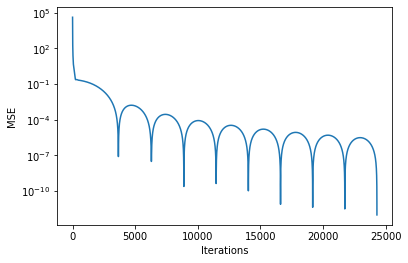

In [35]:
plt.plot(ren(MSElist), MSElist)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()

In [8]:
np.allclose(A2@x1,b2)

True

In [31]:
MSElist[-20:]

[6.4061457329430135e-06,
 5.982033868740941e-06,
 5.572937434187018e-06,
 5.178824030114115e-06,
 4.799661152273679e-06,
 4.435416174995224e-06,
 4.086056334369877e-06,
 3.7515487122365103e-06,
 3.431860220293539e-06,
 3.126957584580695e-06,
 2.8368073311668156e-06,
 2.5613757711665754e-06,
 2.300628987215586e-06,
 2.0545328197693386e-06,
 1.823052854339791e-06,
 1.6061544093134141e-06,
 1.4038025237890395e-06,
 1.2159619467172168e-06,
 1.0425971257183797e-06,
 8.836721972596595e-07]

In [36]:
epsilon*epsilon

1e-24

In [94]:
# Old model - failed
init_time = time.time()
x1 = rng.random(len(A1[0])) # generate a len n vector x
x0 = deepcopy(x1)
z0 = deepcopy(x1)
L = np.max(np.linalg.svd(A1@A1.T)[1]) # L
Grad = A1.T @ ( A1 @ x1 - b1 )
ApproxGrad = deepcopy(Grad)
ApproxGradNorm = np.linalg.norm(ApproxGrad)
AprGrList = [ApproxGradNorm]
timeList = [time.time() - init_time]
lam0 = 1
while ApproxGradNorm > epsilon:
    lam = (1+np.sqrt(1+4*lam0**2))/2
    gamma = (1-lam0)/lam
    Grad = A1.T @ ( A1 @ x1 - b1 )
    z1 = x1 - Grad/L  
    y = (1-gamma)*z1 + gamma*z0
    x0 = deepcopy(x1)
    z0 = deepcopy(z1)
    x1 = y - A2inv @ (A2@y - b2)
    lam0 = deepcopy(lam)
    ApproxGrad = (x1-x0)/lam
    ApproxGradNorm = np.linalg.norm(ApproxGrad)
    AprGrList.append(ApproxGradNorm)
    timeList.append(time.time() - init_time)